# DS 1005 Hwk 3 - Belief Propagation

## Q1 - Sum-product algorithm 

In [113]:
import numpy as np 
import networkx as nx
from fglib import graphs, nodes, rv, inference, utils
from itertools import product
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [2]:
dist_f3 = [0.5, 0.5]
dist_f4 = [0.4,0.6]
px3x4=np.outer(dist_f3,dist_f4)
print(px3x4)
print(px3x4.shape)
px3x4=np.reshape(px3x4, np.shape(px3x4)+(1,))
print(px3x4)
print(px3x4.shape)
px2_conditioned_x3x4=[[[0.2,0.8],
                     [0.25,0.75],],
                     [[0.7,0.3],
                     [0.3,0.7]]]
print(px2_conditioned_x3x4)
dist_f234 =px3x4*px2_conditioned_x3x4
print(dist_f234)
print(dist_f234.shape)
px2= np.sum(dist_f234, axis=(0,1))
print(px2)
px1_conditioned_x2 = [[0.5,0.5],
                     [0.7,0.3]]
dist_f12 =px2[:,np.newaxis]*px1_conditioned_x2
print(dist_f12)
print(dist_f12.shape)

[[0.2 0.3]
 [0.2 0.3]]
(2, 2)
[[[0.2]
  [0.3]]

 [[0.2]
  [0.3]]]
(2, 2, 1)
[[[0.2, 0.8], [0.25, 0.75]], [[0.7, 0.3], [0.3, 0.7]]]
[[[0.04  0.16 ]
  [0.075 0.225]]

 [[0.14  0.06 ]
  [0.09  0.21 ]]]
(2, 2, 2)
[0.345 0.655]
[[0.1725 0.1725]
 [0.4585 0.1965]]
(2, 2)


In [3]:
def make_debug_graph():

    # Create factor graph
    fg = graphs.FactorGraph()

    # Create variable nodes
    x1 = nodes.VNode("x1", rv.Discrete)
    x2 = nodes.VNode("x2", rv.Discrete)
    x3 = nodes.VNode("x3", rv.Discrete)
    x4 = nodes.VNode("x4", rv.Discrete)

    # Create factor nodes
    f12 = nodes.FNode("f12")
    f234 = nodes.FNode("f234")
    f3 = nodes.FNode("f3")
    f4 = nodes.FNode("f4")

    # Add nodes to factor graph
    fg.set_nodes([x1, x2, x3, x4])
    fg.set_nodes([f12, f234, f3,f4 ])

    # Add edges to factor graph
    fg.set_edge(x1, f12)
    fg.set_edge(f12, x2)
    fg.set_edge(x2, f234)
    fg.set_edge(f234, x3)
    fg.set_edge(f234, x4)
    fg.set_edge(x3, f3)
    fg.set_edge(x4, f4)

    #add potential for f_3: p(x3)
    dist_f3 = [0.5, 0.5]
    f3.factor = rv.Discrete(dist_f3,x3)
    
    #add potential for f_4: p(x4)
    dist_f4 = [0.4,0.6]
    f4.factor = rv.Discrete(dist_f4,x4)
    
    # add potential for f_{234}: p(x2, x3, x4) = p(x2|x3,x4) p(x3,x4)
    px3x4=np.outer(dist_f3,dist_f4)
    px3x4=np.reshape(px3x4, np.shape(px3x4)+(1,))
    px2_conditioned_x3x4=[[[0.2,0.8],
                         [0.25,0.75],],
                         [[0.7,0.3],
                         [0.3,0.7]]]
    
    dist_f234 =px3x4*px2_conditioned_x3x4
    f234.factor = rv.Discrete(dist_f234,x3,x4,x2)
   
    # add potential for f_{12}:  p (x1,x2) = p(x1 | x2) p(x2)
    px1_conditioned_x2 = [[0.5,0.5],
                         [0.7,0.3]]
    px2= np.sum(dist_f234, axis=(0,1))
    dist_f12 =px2[:,np.newaxis]*px1_conditioned_x2
    f12.factor = rv.Discrete(dist_f12,x2,x1)
    # Perform sum-product algorithm on factor graph
    # and request belief of variable node x1
    
    belief = inference.sum_product(fg, x1)
    print(belief)
    return (fg)


### 1a. Implement sum-product algorithm 

In [4]:
# # numerically unstable 

# def get_beliefs(model, n_iter=10):
    
#     # initialize variable to factor messages 
#     for v in model.get_vnodes():
#         for f in v.neighbors():
#             initial_msg = rv.Discrete(np.ones(2,), v)
#             model[v][f]['object'].set_message(v, f, initial_msg)

#     # run parallel updates for n_iter times 
#     for i in range(n_iter):
        
#         # update factor-to-variable messages
#         for f in model.get_fnodes():
#             for v in f.neighbors():
#                 msg = f.factor 
#                 for n in f.neighbors(exclusion=v):
#                     msg *= model[n][f]['object'].get_message(n, f)
#                 for n in f.neighbors(exclusion=v):
#                     msg = msg.marginalize(n, normalize=False)
#                 model[f][v]['object'].set_message(f, v, msg)
                
#         # update variable-to-factor messages 
#         for v in model.get_vnodes(): 
#             for f in v.neighbors():
#                 msg = rv.Discrete(np.ones(2,), v)
#                 for n in v.neighbors(exclusion=f):
#                     msg *= model[n][v]['object'].get_message(n, v)
#                 model[v][f]['object'].set_message(v, f, msg)

#         # store beliefs of variable nodes 
#         beliefs = {}
#         for v in model.get_vnodes():
#             beliefs[v] = v.belief(model)
    
#     return beliefs

In [5]:
def get_beliefs(model, n_iter=10):
    
    # initialize variable to factor messages 
    for v in model.get_vnodes():
        for f in v.neighbors():
            initial_msg = rv.Discrete(np.ones(2,), v)
            model[v][f]['object'].set_message(v, f, initial_msg.normalize())

    # run parallel updates for n_iter times 
    for i in range(n_iter):
        
        # update factor-to-variable messages
        for f in model.get_fnodes():
            for v in f.neighbors():
                msg = f.factor 
                for n in f.neighbors(exclusion=v):
                    msg *= model[n][f]['object'].get_message(n, f)
                    msg = msg.normalize()
                for n in f.neighbors(exclusion=v):
                    msg = msg.marginalize(n, normalize=True)
                model[f][v]['object'].set_message(f, v, msg.normalize())
                
        # update variable-to-factor messages 
        for v in model.get_vnodes(): 
            for f in v.neighbors():
                msg = rv.Discrete(np.ones(2,), v)
                for n in v.neighbors(exclusion=f):
                    msg *= model[n][v]['object'].get_message(n, v)
                    msg = msg.normalize()
                model[v][f]['object'].set_message(v, f, msg.normalize())

        # store beliefs of variable nodes 
        beliefs = {}
        for v in model.get_vnodes():
            belief = rv.Discrete(np.ones(2,), v)
            for n in v.neighbors():
                belief *= model[n][v]['object'].get_message(n, v)
            beliefs[v] = belief.normalize()
    
    return beliefs

In [6]:
# # attempt to take log, but answers don't seem correct

# def get_beliefs_log(model, n_iter=10):
    
#     # initialize variable to factor messages 
#     for v in model.get_vnodes():
#         for f in v.neighbors():
#             initial_msg = rv.Discrete(np.ones(2,), v).normalize().log()
#             model[v][f]['object'].set_message(v, f, initial_msg, logarithmic=True)

#     # run parallel updates for n_iter times 
#     for i in range(n_iter):
        
#         # update factor-to-variable messages
#         for f in model.get_fnodes():
#             for v in f.neighbors():
#                 sum_lambdas = rv.Discrete(np.zeros(2,), v)
#                 for n in f.neighbors(exclusion=v):
#                     sum_lambdas += model[n][f]['object'].get_message(n, f)
#                 max_lambda = max(np.nan_to_num(sum_lambdas.pmf.flatten()))
#                 sum_lambdas = rv.Discrete(sum_lambdas.pmf - max_lambda, v)
#                 msg = rv.Discrete(np.exp(sum_lambdas.pmf), *sum_lambdas.dim)
#                 msg = f.factor * msg
#                 for n in f.neighbors(exclusion=v):
#                     msg = msg.marginalize(n, normalize=False)
#                 msg = msg.log()
#                 msg = rv.Discrete(msg.pmf + max_lambda, v)
#                 msg = msg.normalize()
#                 model[f][v]['object'].set_message(f, v, msg, logarithmic=True)
                
#         # update variable-to-factor messages 
#         for v in model.get_vnodes(): 
#             for f in v.neighbors():
#                 msg = rv.Discrete(np.zeros(2,), v)
#                 for n in v.neighbors(exclusion=f):
#                     msg += model[n][v]['object'].get_message(n, v)
#                 model[v][f]['object'].set_message(v, f, msg, logarithmic=True)

#         # store beliefs of variable nodes 
#         beliefs = {}
#         for v in model.get_vnodes():
#             log_b = v.belief(normalize=False)
#             b = rv.Discrete(np.exp(log_b.pmf), log_b.dim).normalize()
#             beliefs[v] = b
    
#     return beliefs

### 1b. Test on 4-node factor graph provided 

In [7]:
fg = make_debug_graph()
beliefs = get_beliefs(fg)
print("Belief of variable nodes ")
for (v,b) in beliefs.items():
    print(v, b)

[0.65897284 0.34102716]
Belief of variable nodes 
x1 [0.65897284 0.34102716]
x2 [0.20513578 0.79486422]
x3 [0.52640912 0.47359088]
x4 [0.28679718 0.71320282]


## Q2 - Low-Density Priority Check (LDPC)

In [8]:
from pyldpc import RegularH, CodingMatrixG # old version of API

### Part a:  

In [11]:
def get_factor_potentials(d_v): # where d_v = num of variable nodes in parity check equation 
    permutations = product([0,1], repeat=d_v)
    phi = np.zeros([2 for i in range(d_v)])
    for idx in permutations:
        if sum(idx) % 2 == 0: 
            phi[idx] = 1
        else:
            phi[idx] = 0
    return phi 

In [12]:
def make_ldpc_fg(H):
    """ Given an arbitrary parity check matrix create a corresponding factor graph """
    
    # initialize factor graph  
    fg = graphs.FactorGraph()
    
    # infer the number of factor and variable nodes required
    num_factors, num_variables = H.shape

    # create factor nodes 
    fnodes = [] 
    for i in range(num_factors):
        fnodes.append(nodes.FNode("f" + str(i)))
    
    # create variable nodes 
    vnodes = [] 
    for j in range(num_variables):
        vnodes.append(nodes.VNode("x" + str(j), rv.Discrete))
        
    # add nodes to factor graph 
    fg.set_nodes(vnodes)
    fg.set_nodes(fnodes)
    
    # add edges to factor graph based on H 
    for i in range(num_factors):
        for j in range(num_variables):
            if H[i,j] == 1:
                fg.set_edge(fnodes[i], vnodes[j])
                
    # set factor potentials 
    for fnode in fg.get_fnodes():
        vnodes2check = [vnode for vnode in fnode.neighbors()]
        fnode_potentials = get_factor_potentials(len(vnodes2check))
        fnode.factor = rv.Discrete(fnode_potentials, *vnodes2check)
        
    return fg

In [13]:
# create parity check matrix (note d_v = ones per column, d_c = ones per row)
H = RegularH(n=8, d_v=2, d_c=4)
print(H)
ldpc_fg = make_ldpc_fg(H)

[[1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [1 0 1 1 0 0 0 1]
 [0 1 0 0 1 1 1 0]]


In [63]:
def evaluate_potential(model, codeword):
    p = 1
    for f in model.get_fnodes():
        v_checked = [int(str(v)[1:]) for v in f.neighbors()]
        idx = tuple([codeword[i] for i in v_checked])
        p *= f.factor.pmf[idx]
    return p

In [64]:
# define invalid codewords 
invalid_code = np.array([1, 0, 0, 0, 0, 0, 0, 0]) # should fail parity check 
print("Given H = {}, this code is expected to fail parity check: {}".format(H, invalid_code))
prob = evaluate_potential(ldpc_fg, invalid_code)
print("Prob is {}".format(prob))

Given H = [[1 1 1 1 0 0 0 0]
 [0 0 0 0 1 1 1 1]
 [1 0 1 1 0 0 0 1]
 [0 1 0 0 1 1 1 0]], this code is expected to fail parity check: [1 0 0 0 0 0 0 0]
Prob is 0.0


In [65]:
# zero should pass 
valid_code = np.zeros(8, dtype=int)
print("Zeros should always pass parity check: {}".format(valid_code))
prob = evaluate_potential(ldpc_fg, valid_code)
print("Prob is {}".format(prob))

Zeros should always pass parity check: [0 0 0 0 0 0 0 0]
Prob is 1.0


### Part b: 128-bit LDPC

In [85]:
def get_unary_potential(bit, err):
    phi = np.zeros(shape=(2,))
    phi[bit] = 1 - err 
    phi[1-bit] = err 
    return phi 

def set_unary_factors(fg, msg, err):
    for vnode in fg.get_vnodes():
        idx = int(str(vnode)[1:])
        phi = get_unary_potential(msg[idx-1], err)
        ufnode = nodes.FNode("u" + str(idx))
        ufnode.factor = rv.Discrete(phi, vnode)
        fg.set_node(ufnode)
        fg.set_edge(ufnode, vnode)
    return fg

def transmit(original, err):
    is_flipped = np.random.rand(len(original)) < err
    transmitted = np.where(is_flipped, 1 - original, original)
    return transmitted

In [101]:
original_codeword = np.zeros(256, dtype=int)
transmitted = transmit(original_codeword, err=.1)
transmitted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1])

In [102]:
H1 = RegularH(n=256, d_v=4, d_c=8)
print(H1.shape)

(128, 256)


In [104]:
ldpc_fg1 = make_ldpc_fg(H1)
ldpc_fg1 = set_unary_factors(ldpc_fg1, transmitted, 0.1)
beliefs = get_beliefs(ldpc_fg1, 50)
for (v,b) in beliefs.items():
    print(v, b)

x0 [0.23926336 0.76073664]
x1 [0.70484963 0.29515037]
x2 [0.92812095 0.07187905]
x3 [0.91331186 0.08668814]
x4 [0.78710185 0.21289815]
x5 [0.93936156 0.06063844]
x6 [0.94903912 0.05096088]
x7 [0.90368456 0.09631544]
x8 [0.86676946 0.13323054]
x9 [0.94438684 0.05561316]
x10 [0.91100666 0.08899334]
x11 [0.31905433 0.68094567]
x12 [0.87744718 0.12255282]
x13 [0.84853342 0.15146658]
x14 [0.88345686 0.11654314]
x15 [0.90239909 0.09760091]
x16 [0.87072907 0.12927093]
x17 [0.05294376 0.94705624]
x18 [0.89496116 0.10503884]
x19 [0.79497796 0.20502204]
x20 [0.91632167 0.08367833]
x21 [0.83386147 0.16613853]
x22 [0.70393627 0.29606373]
x23 [0.8120391 0.1879609]
x24 [0.79574204 0.20425796]
x25 [0.95068243 0.04931757]
x26 [0.97060226 0.02939774]
x27 [0.82470667 0.17529333]
x28 [0.68659212 0.31340788]
x29 [0.24400617 0.75599383]
x30 [0.80043448 0.19956552]
x31 [0.87763218 0.12236782]
x32 [0.15399455 0.84600545]
x33 [0.92208812 0.07791188]
x34 [0.97164078 0.02835922]
x35 [0.89702881 0.10297119]
x36 

### Part E 

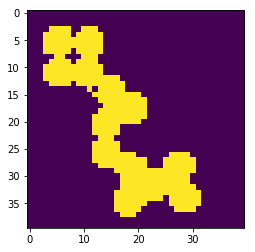

In [126]:
img = cv2.imread('binary-image.png',2)
img = cv2.resize(img, (40, 40))
ret, bw_img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
#cv2.imshow("Binary Image",bw_img)
plt.imshow(bw_img)

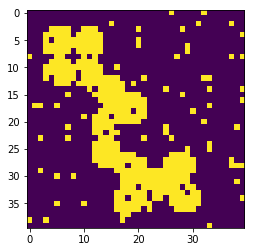

In [137]:
img_code = (bw_img / 255).astype(int)
img_code_flattened = img_code.flatten()
img_code_transmitted = transmit(img_code_flattened, err=0.05)
transmitted_reshaped = img_code_transmitted.reshape(img_code.shape)
plt.imshow(transmitted_reshaped)

## Q4 - Messsage passing on a tree

In [ ]:
from scipy.stats import norm

In [ ]:
norm.pdf(50, loc=50, scale=np.sqrt(10))

In [ ]:
norm.pdf(50, loc=60, scale=np.sqrt(10))

In [ ]:
norm.pdf(60, loc=50, scale=np.sqrt(10))

In [ ]:
norm.pdf(60, loc=60, scale=np.sqrt(10))